# Time Series Forecasting on Energy Consumption Dataset

Using Xgboost on time series forecasting

Followed https://www.youtube.com/watch?v=vV12dGe_Fho and the notebook

Added changes like hyperparameter tuning and added lag features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
# import weights and biases
# import wandb

In [2]:
# Read CSV file
df = pd.read_csv("archive/PJME_hourly.csv")

# Set the index of dataframe to Datetime (standard for timeseries data)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [3]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


# Plot Dataset

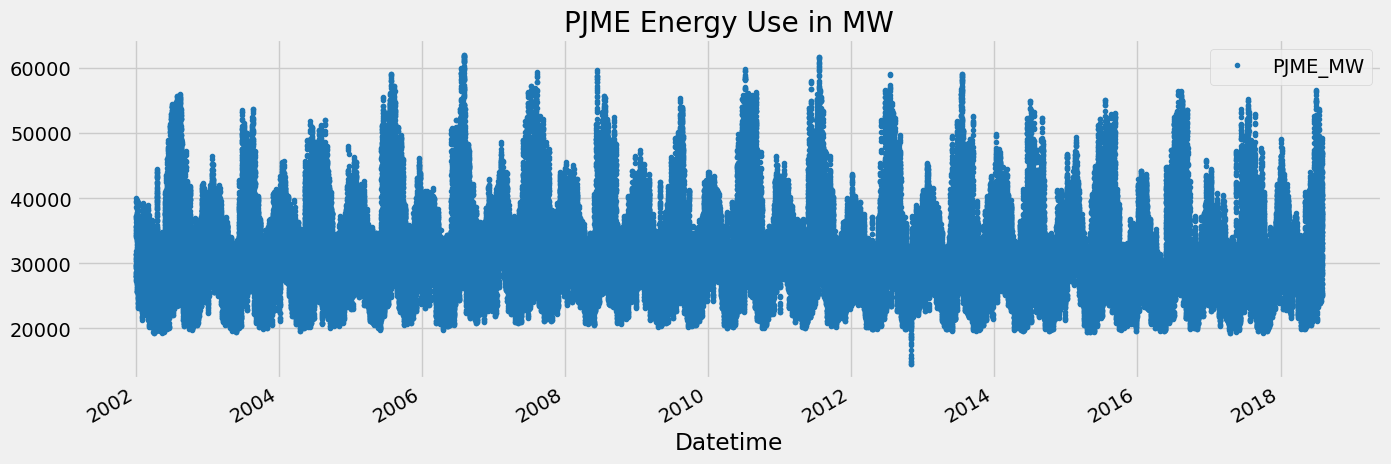

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

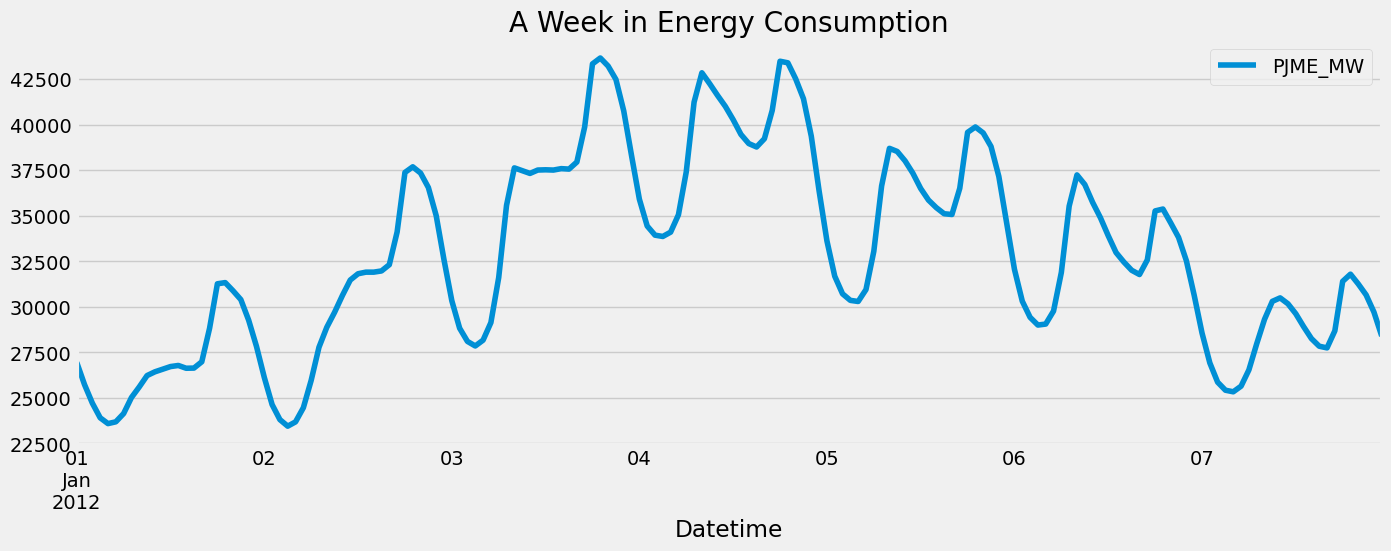

In [5]:
df.loc['2012-01-01':'2012-01-07'].plot(figsize=(15, 5), title="A Week in Energy Consumption")
plt.show()

# Train/Test Split

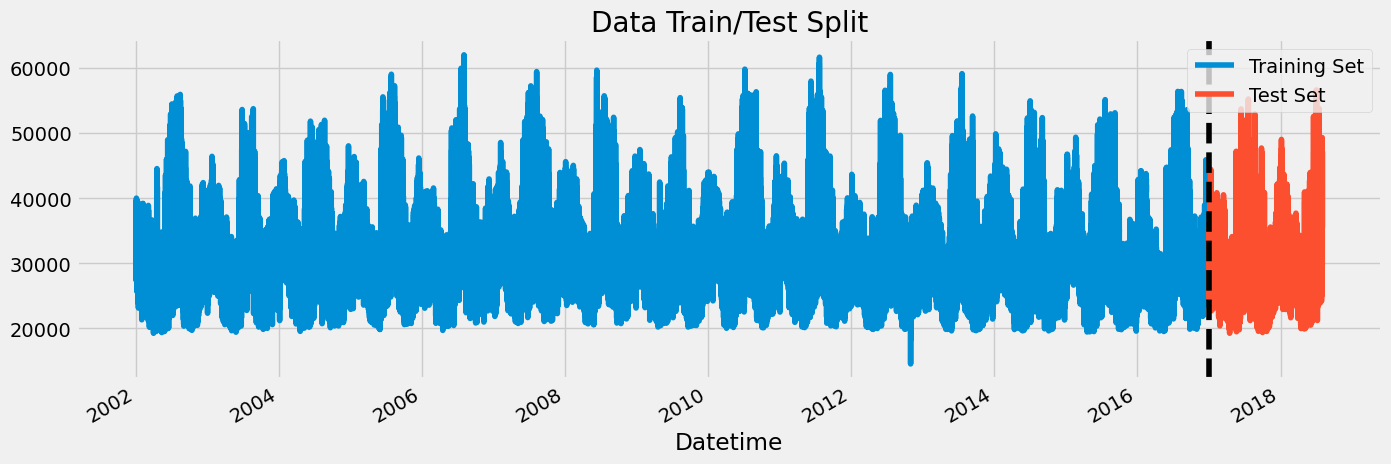

In [6]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Creating Features

In [7]:
# Create features from time series index
def create_features(df):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter

    return df

In [8]:
df = create_features(df)

Text(0.5, 1.0, 'MW by hour')

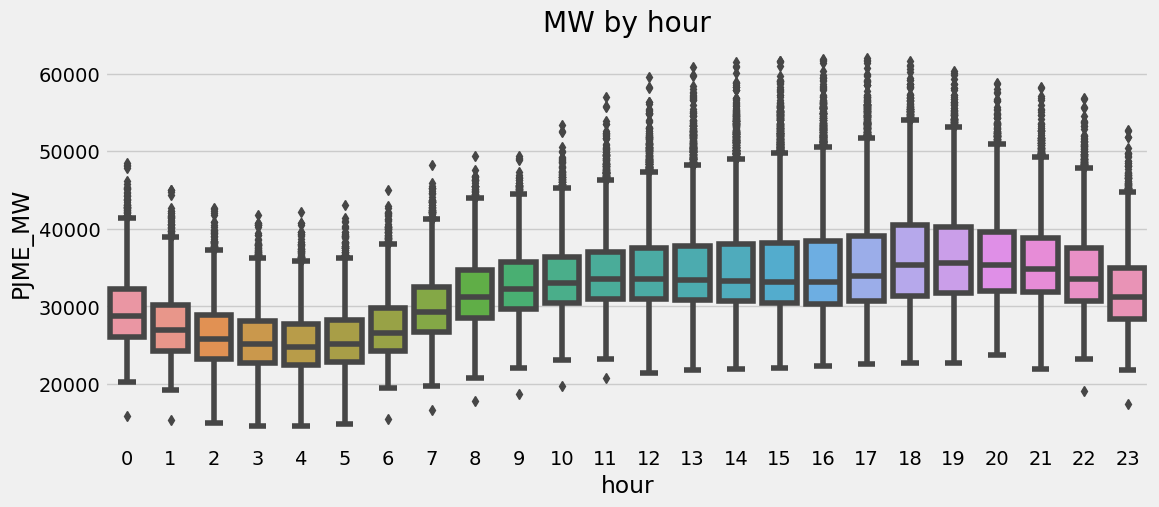

In [9]:
# Plot relationships

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='hour', y = 'PJME_MW')
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by month')

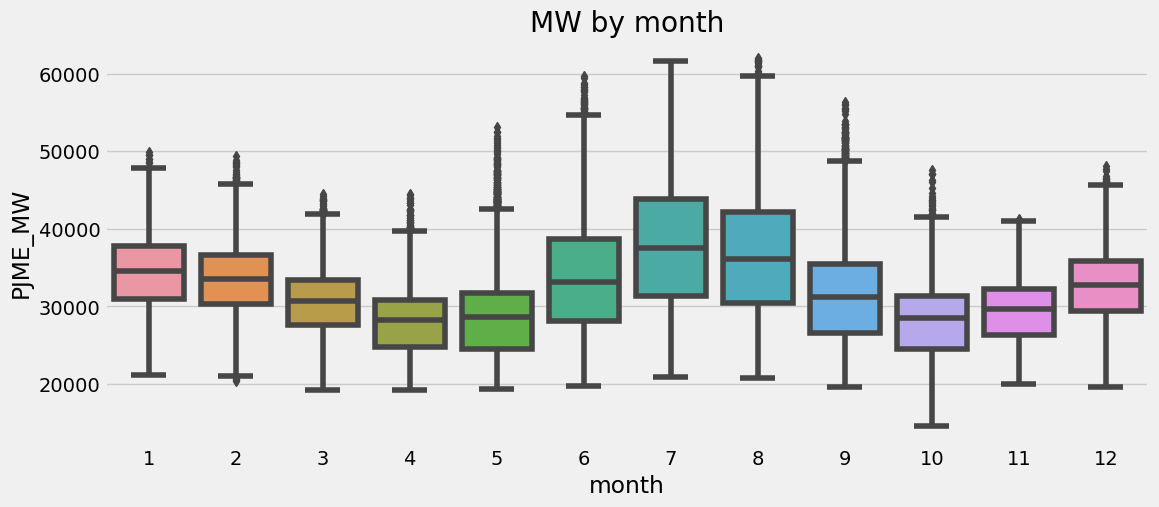

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='month', y = 'PJME_MW')
ax.set_title('MW by month')

Text(0.5, 1.0, 'MW by Day of Week')

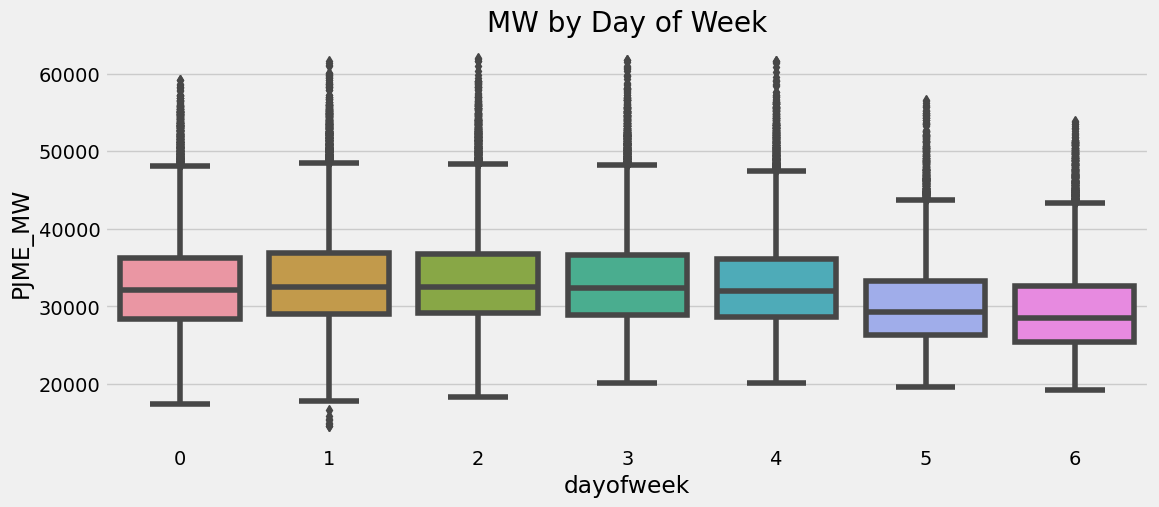

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='dayofweek', y = 'PJME_MW')
ax.set_title('MW by Day of Week')

# Create Lag Features

In [12]:
# add lag features: what was the target x days in the past

target_map = df['PJME_MW'].to_dict()

def add_lags(df):

    target_map = df['PJME_MW'].to_dict()

    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df

In [13]:
df = add_lags(df)

In [14]:
df.tail()

,PJME_MW,hour,dayofweek,month,year,quarter,lag1,lag2,lag3
Datetime,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,8,2018,3,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,8,2018,3,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,8,2018,3,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,8,2018,3,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,8,2018,3,33539.0,32094.0,31695.0



# Model

In [15]:
# Cross Validation
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)

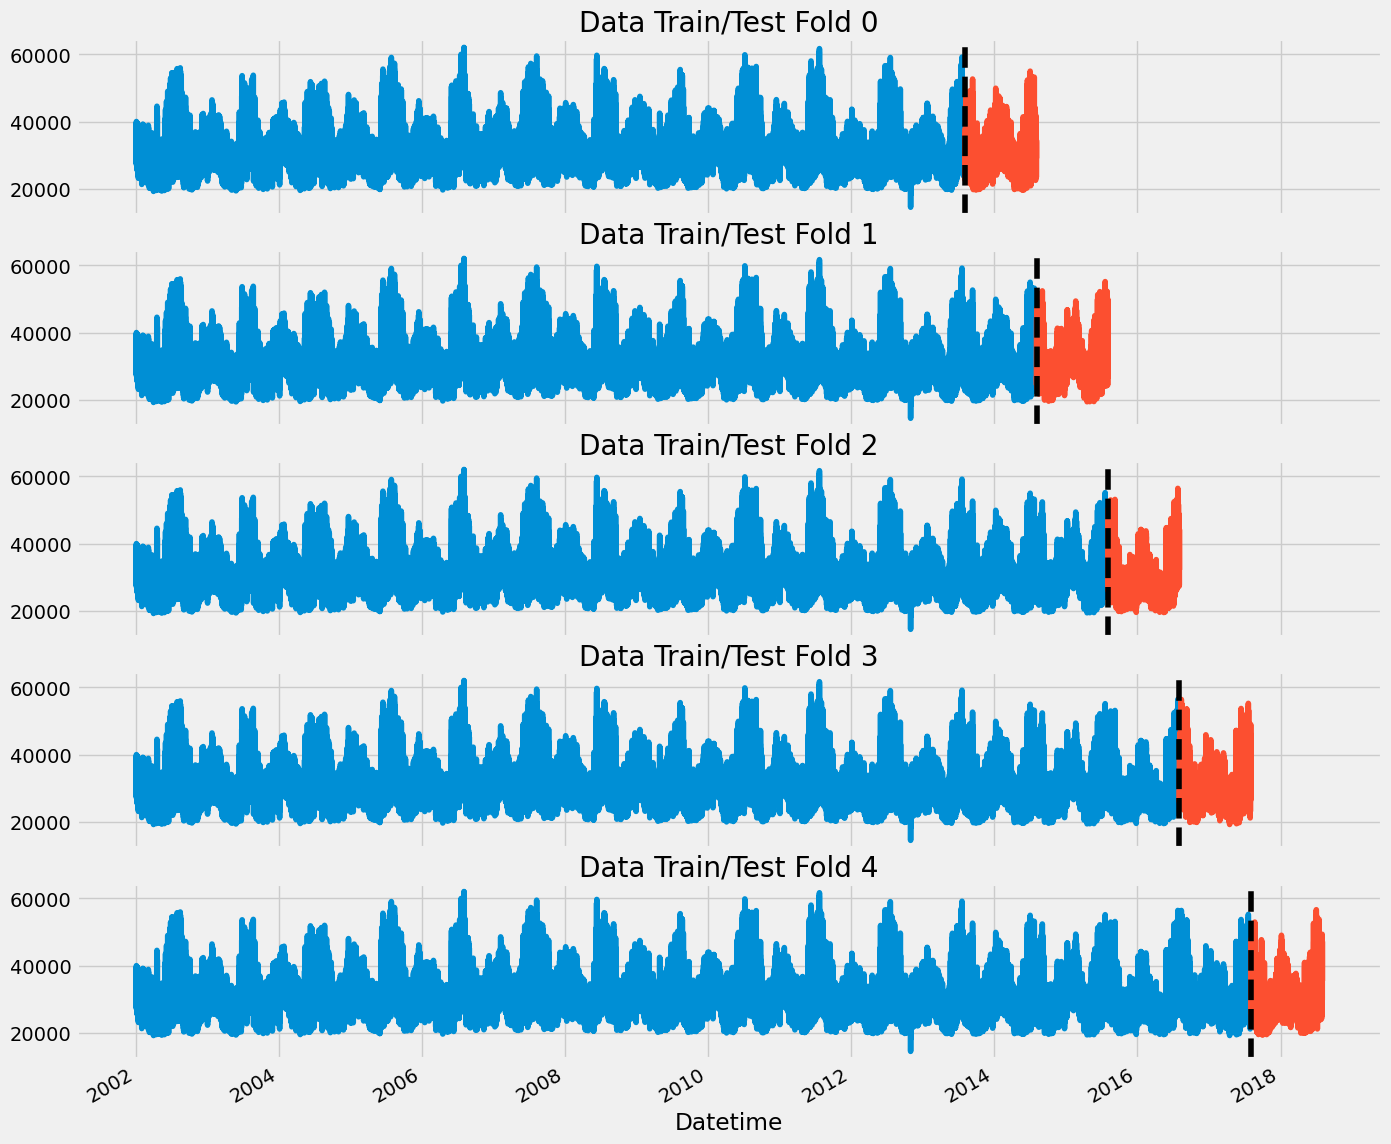

In [16]:

fig, axs = plt.subplots(5,1, figsize = (15,15), sharex = True)

fold = 0

for train_ind, val_ind in tss.split(df):
    train = df.iloc[train_ind]
    test = df.iloc[val_ind] 

    train['PJME_MW'].plot(ax=axs[fold],
                          label = 'Training Set',
                          title = f'Data Train/Test Fold {fold}' )
    test['PJME_MW'].plot(ax=axs[fold],
                      label = 'Test Set')

    axs[fold].axvline(test.index.min(), color = 'black', ls= '--')

    fold += 1

plt.show()


In [23]:
# Hyperparamter Tuning (Gridsearch)
n_estimators =[500,1000]
max_depth = [3,6]
learning_rate = [0.01,0.005]


In [26]:
def train(df, n_estimators, max_depth, learning_rate):

    best_avg_score = float('inf')

    best_n_estimators = 0
    best_max_depth = 0
    best_learning_rate = 0
    
    for i in n_estimators:
        for k in max_depth:
            for l in learning_rate:

                print(f"N estimators: {i} Max Depth: {k}, lr: {l}")
                
                # Training
                # Model and model parameters
                reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                                       n_estimators = i, 
                                       early_stopping_rounds = 50,
                                       objective = 'reg:squarederror',
                                       max_depth = k,
                                       learning_rate = l)
                
                fold = 0
                preds = []
                scores = []
                
                # Cross Validation
                for train_ind, val_ind in tss.split(df):
                    train = df.iloc[train_ind]
                    test = df.iloc[val_ind] 
                
                    FEATURES = ['dayofweek', 'hour', 'month', 'year', 'quarter', 'lag1','lag2','lag3']
                    TARGET = 'PJME_MW'
                
                    x_train = train[FEATURES]
                    y_train = train[TARGET]
                
                    x_test = test[FEATURES]
                    y_test = test[TARGET]
                
                    reg.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100 )
                
                
                    y_pred = reg.predict(x_test)
                    preds.append(y_pred)
                
                
                    score = np.sqrt(mean_squared_error(y_test, y_pred))
                    scores.append(score)


                # get best current hyperparamters
                if np.mean(scores) < best_avg_score:
                    best_avg_score = np.mean(scores)

                    best_n_estimators = i
                    best_max_depth = k
                    best_learning_rate = l

    return [best_n_estimators, best_max_depth, best_learning_rate]

In [27]:
best_params = train(df, n_estimators, max_depth, learning_rate)

N estimators: 500 Max Depth: 3, lr: 0.01
[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992
[100]	validation_0-rmse:12534.63181	validation_1-rmse:11914.15188
[200]	validation_0-rmse:5764.97680	validation_1-rmse:5382.25108
[300]	validation_0-rmse:3907.37762	validation_1-rmse:3918.16595
[400]	validation_0-rmse:3476.97227	validation_1-rmse:3784.63280
[440]	validation_0-rmse:3417.73549	validation_1-rmse:3786.78913
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280
[100]	validation_0-rmse:12515.84298	validation_1-rmse:12221.69332
[200]	validation_0-rmse:5765.30795	validation_1-rmse:5667.12147
[300]	validation_0-rmse:3939.72969	validation_1-rmse:3961.58681
[400]	validation_0-rmse:3515.63503	validation_1-rmse:3637.10874
[499]	validation_0-rmse:3395.39940	validation_1-rmse:3567.65127
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137
[100]	validation_0-rmse:12500.45982	validation_1-rmse:11132.46465
[200]	validation_0-rmse:5760.83414	validation_1-rmse:4844

In [29]:
print(f'Best params after hyperparamter tuning and cross validation {best_params}')

Best params after hyperparamter tuning and cross validation [1000, 3, 0.01]


In [31]:
# Model and model parameters
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                       n_estimators = 1000, 
                       early_stopping_rounds = 50,
                       objective = 'reg:squarederror',
                       max_depth = 3,
                       learning_rate = 0.01)

In [32]:
fold = 0
preds = []
scores = []

# Cross Validation
for train_ind, val_ind in tss.split(df):
    train = df.iloc[train_ind]
    test = df.iloc[val_ind] 

    FEATURES = ['dayofweek', 'hour', 'month', 'year', 'quarter', 'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    x_train = train[FEATURES]
    y_train = train[TARGET]

    x_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100 )


    y_pred = reg.predict(x_test)
    preds.append(y_pred)


    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992
[100]	validation_0-rmse:12534.63181	validation_1-rmse:11914.15188
[200]	validation_0-rmse:5764.97680	validation_1-rmse:5382.25108
[300]	validation_0-rmse:3907.37762	validation_1-rmse:3918.16595
[400]	validation_0-rmse:3476.97227	validation_1-rmse:3784.63280
[441]	validation_0-rmse:3416.23684	validation_1-rmse:3787.38951
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280
[100]	validation_0-rmse:12515.84298	validation_1-rmse:12221.69332
[200]	validation_0-rmse:5765.30795	validation_1-rmse:5667.12147
[300]	validation_0-rmse:3939.72969	validation_1-rmse:3961.58681
[400]	validation_0-rmse:3515.63503	validation_1-rmse:3637.10874
[500]	validation_0-rmse:3394.88174	validation_1-rmse:3567.29094
[600]	validation_0-rmse:3339.22400	validation_1-rmse:3537.86616
[700]	validation_0-rmse:3301.44662	validation_1-rmse:3507.77022
[800]	validation_0-rmse:3271.25920	validation_1-rmse:3480.73032
[900]	validation_0-rmse:3246.71332	v

In [33]:
feature_importance = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ['importance'])

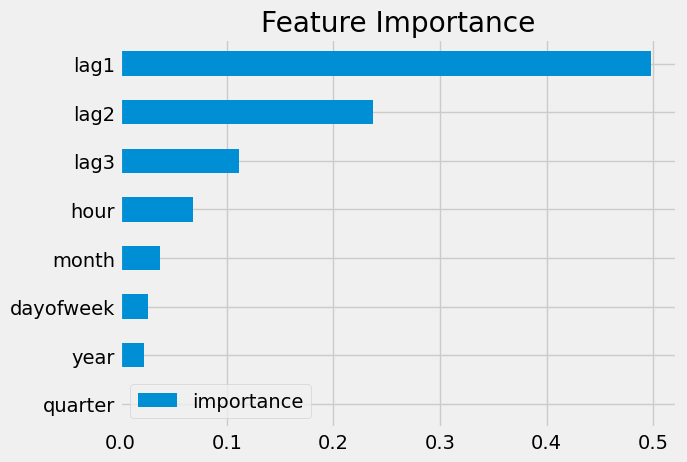

In [34]:
feature_importance.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [35]:
# Predict and evaluate on test set (last of cross validation)
test['pred'] = reg.predict(x_test)

C:\Users\Dat Duong\AppData\Local\Temp\ipykernel_7440\2046735518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = reg.predict(x_test)


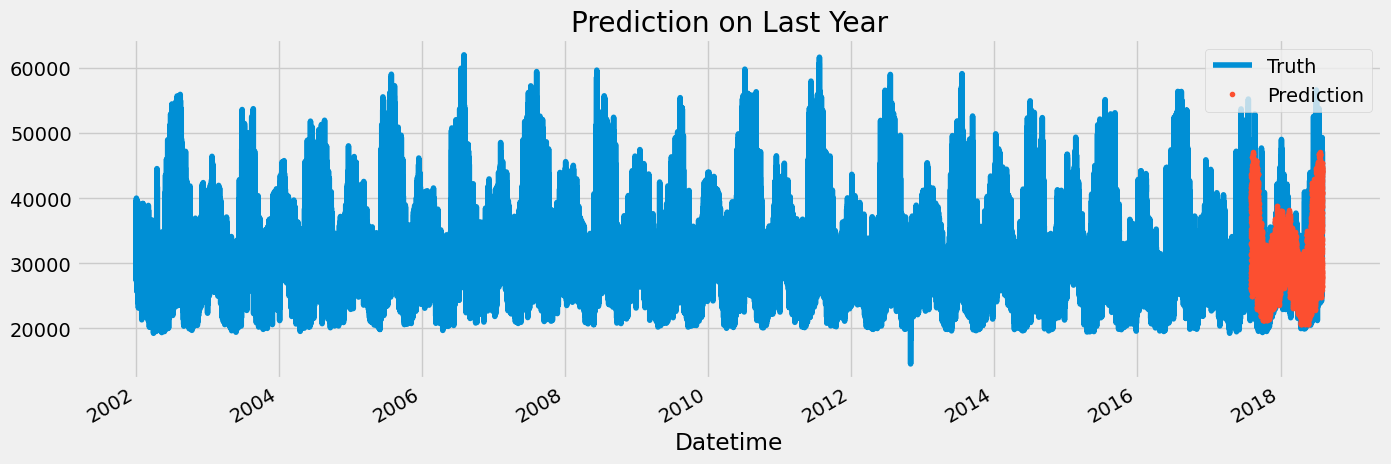

In [38]:
df= df.merge(test[['pred']], how = 'left', left_index = True, right_index = True)
ax = df[['PJME_MW']].plot(figsize =(15,5))
df['pred'].plot(ax=ax, style = '.')
plt.legend(['Truth', 'Prediction'])
ax.set_title('Prediction on Last Year')
plt.show()
             

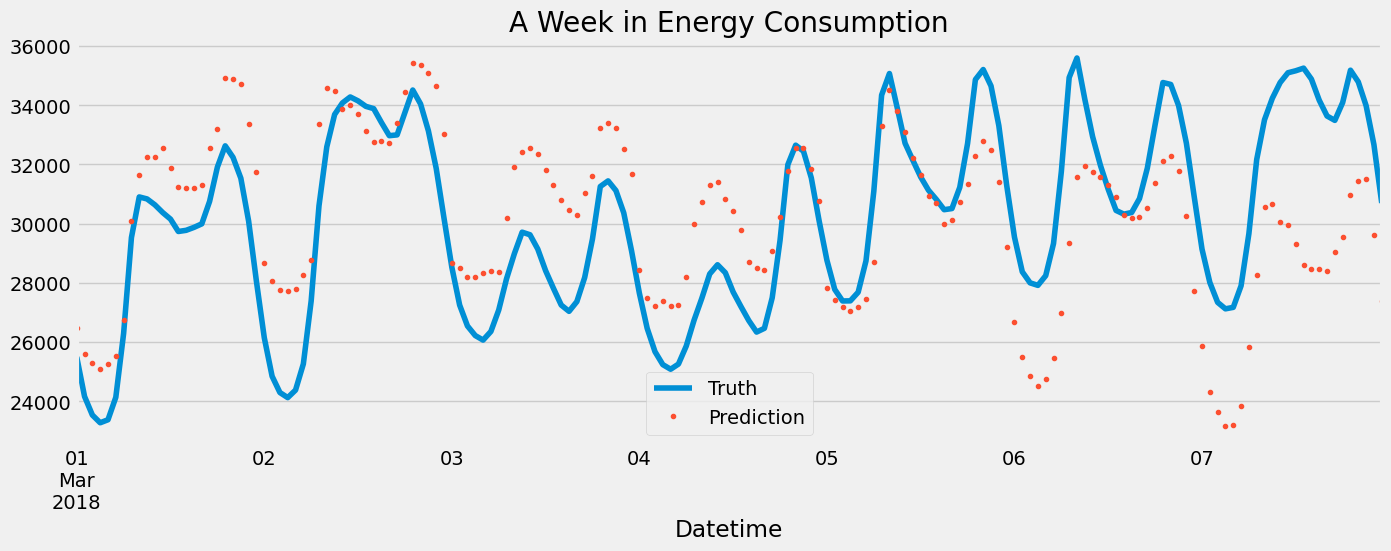

In [39]:
ax = df.loc['2018-03-01':'2018-03-07']['PJME_MW'].plot(figsize=(15, 5), title="A Week in Energy Consumption")
df.loc['2018-03-01':'2018-03-07']['pred'].plot(style = '.')
plt.legend(['Truth', 'Prediction'])
plt.show()